In [1]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

In [2]:
## loading the data directory --
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "..\\Data\\animals\\",
    batch_size=32, 
    image_size=(256,256),
    shuffle=True
)

Found 5400 files belonging to 90 classes.


In [3]:
## class_names
class_names = dataset.class_names
class_names

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat',
 'caterpillar',
 'chimpanzee',
 'cockroach',
 'cow',
 'coyote',
 'crab',
 'crow',
 'deer',
 'dog',
 'dolphin',
 'donkey',
 'dragonfly',
 'duck',
 'eagle',
 'elephant',
 'flamingo',
 'fly',
 'fox',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'grasshopper',
 'hamster',
 'hare',
 'hedgehog',
 'hippopotamus',
 'hornbill',
 'horse',
 'hummingbird',
 'hyena',
 'jellyfish',
 'kangaroo',
 'koala',
 'ladybugs',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'mosquito',
 'moth',
 'mouse',
 'octopus',
 'okapi',
 'orangutan',
 'otter',
 'owl',
 'ox',
 'oyster',
 'panda',
 'parrot',
 'pelecaniformes',
 'penguin',
 'pig',
 'pigeon',
 'porcupine',
 'possum',
 'raccoon',
 'rat',
 'reindeer',
 'rhinoceros',
 'sandpiper',
 'seahorse',
 'seal',
 'shark',
 'sheep',
 'snake',
 'sparrow',
 'squid',
 'squirrel',
 'starfish',
 'swan',
 'tiger',
 'turkey',
 'turtle',
 'whale',
 'wolf',
 'wombat',
 'woodpecker',


In [4]:
len(dataset) ## 32 images per batch ==> 169*32=5408

169

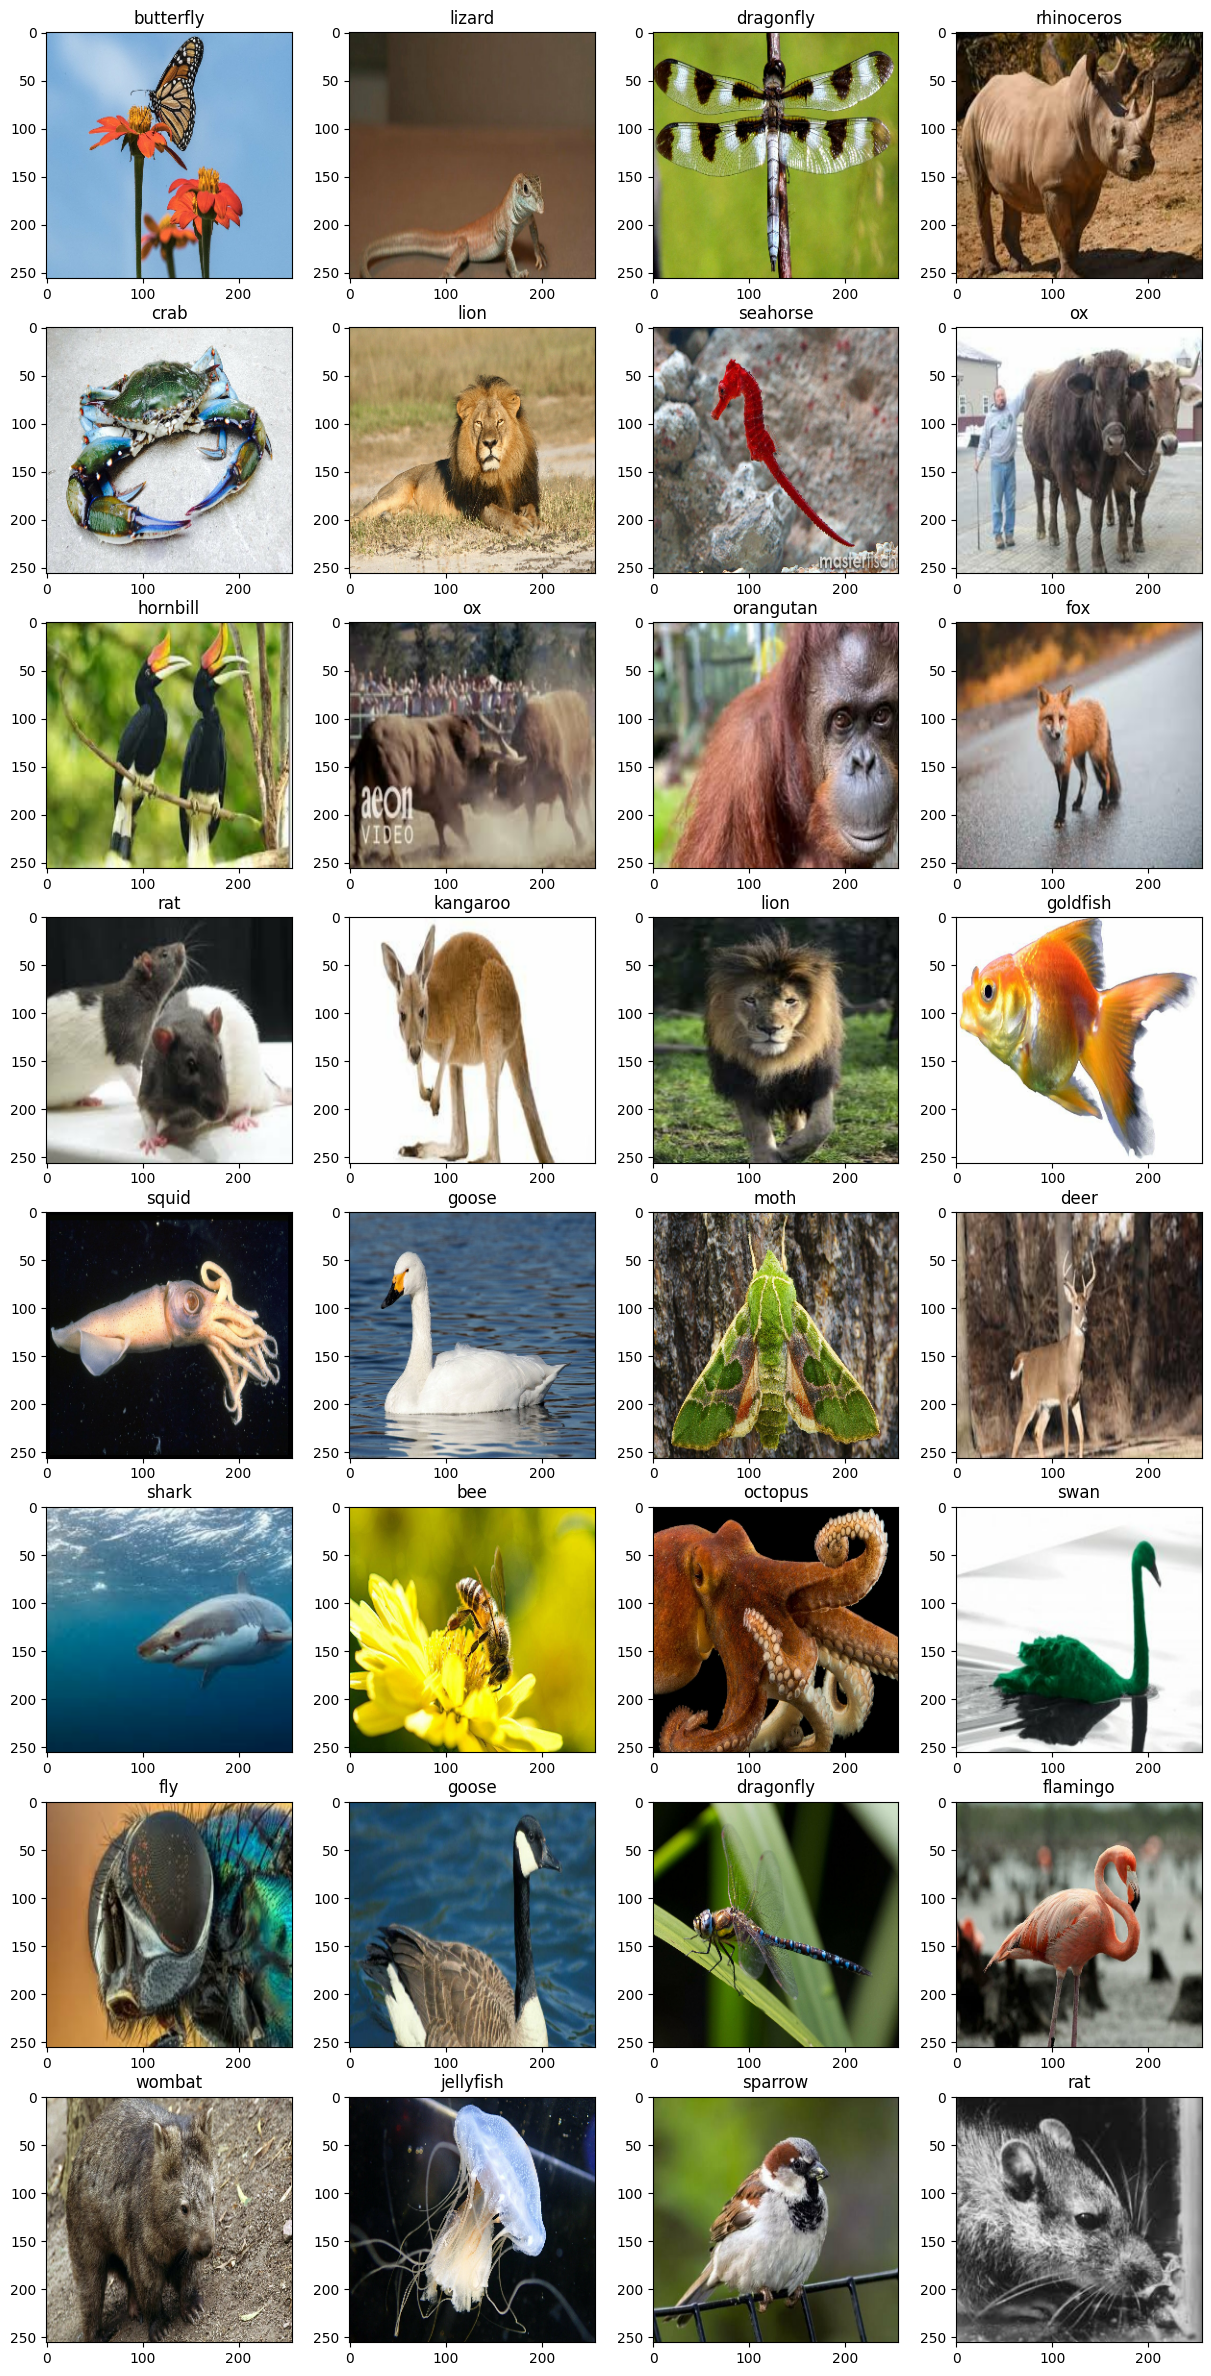

In [5]:
plt.figure(figsize=(15,30))
for image_batch,label_batch in dataset.take(1):
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

# Splitting the Dataset into Train(80%),Test(10%) and Validation(10%)

In [6]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size = len(dataset)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size) 

    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,validation_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [8]:
len(train_ds),len(test_ds),len(val_ds)

(135, 18, 16)

## Resizing and Rescaling

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0*256)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [12]:
def process(image,label):
    image = tf.cast(image/256.,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

## Transfer Learing (Pretrained model )

In [13]:
conv_base = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

In [14]:
conv_base.trainable = False

In [15]:
model = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)), 
    resize_and_rescale,
    data_augmentation,
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(90, activation='softmax')
])

D:\Artificial Intelligence\Deep Learning\Project2\image_classification\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,439,298 (207.67 MB)

 Trainable params: 33,577,818 (128.09 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [17]:
model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(train_ds,epochs=5,validation_data=val_ds)

Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.0144 - loss: 22.4724 - val_accuracy: 0.0156 - val_loss: 4.8669
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.0139 - loss: 4.6398 - val_accuracy: 0.0098 - val_loss: 4.5666
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.0137 - loss: 4.5258 - val_accuracy: 0.0117 - val_loss: 4.4947
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.0135 - loss: 4.5247 - val_accuracy: 0.0176 - val_loss: 4.5029
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.0176 - loss: 4.5170 - val_accuracy: 0.0137 - val_loss: 4.5366


In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
import numpy as np

In [ ]:
for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image prediction : ")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predicions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predicions[0])]
    confidence = round(100*(np.max(predicions[0])),2)
    return predicted_class,confidence

In [ ]:
plt.figure(figsize=(15,35))
for images,labels in test_ds.take(1):
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\nConfidence: {confidence}")
        plt.axis("off")

In [ ]:
model_version = 1
model.save(f"../models/classifier_model_{model_version}.h5")